In [40]:
#2/7/24 Neural Net for model creation using Combined Mutagen Chemopy Data
#Suppress unneeded low level warning messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
#Data import
#targetdata = pd.read_csv('/Users/james/Documents/Honours/Data/structdata/Mutagen/mutagenMorganfp.csv')

datasets = []
index = []
directory = '/Users/james/Documents/Honours/Data/structdata/Mutagen/chemopy/'
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if 'csv' in filename:
        pathname = directory + file
        df = pd.read_csv(pathname)
        #df.drop(columns=['SMILES'], inplace=True)
        df = df.dropna(axis=1)
        datasets.append(df)
        index.append(file)

targetdata = datasets[0]
for item in datasets[1:]:
    targetdata = pd.concat([targetdata, item.iloc[:,2:]], axis=1)

#Creating test/train splits
from sklearn.model_selection import train_test_split
targetdata, validset = train_test_split(targetdata, test_size=0.2, random_state=81)
trainset, testset = train_test_split(targetdata, test_size=0.2, random_state=81)
#Converts Toxicity Values to a list
temp = trainset['Toxicity_Values']
ytrain = []
for items in temp:
    ytrain.append(items)
ytest = testset['Toxicity_Values'].values
#Converts encoded drug target values to an array
xtrain = trainset.iloc[:, 2:].values
xtest = testset.iloc[:, 2:].values

In [41]:
targetdata

,SMILES,Toxicity_Values,kappam1,kappam2,kappam3,phi,kappa1,kappa2,kappa3,IC0,...,Save,Smax,Smin,DS,MR,LogP,LogP2,TPSA,UI,Hy
5282,O=C(OCc1ccc(Cl)cc1)c1cccc2cccnc12,0,13.586547,5.935576,3.033601,3.840190,15.879017,7.513007,4.050000,1.574503,...,2.338624,12.210630,-0.380324,12.590954,82.3145,4.2452,18.021723,39.19,4.247928,-1.150319
6579,c1ccc2c(C3CO3)c3ccc4ccccc4c3cc2c1,1,11.298123,4.060821,1.613363,2.184745,13.440000,5.273923,2.222222,1.136668,...,1.904762,5.622829,0.263669,5.359161,87.6530,5.2175,27.222306,12.53,4.459432,-1.353317
1006,C=CC(=O)OCC(C)C,0,8.210000,4.125078,5.074900,3.762988,9.000000,4.839506,5.877551,1.312744,...,2.666667,10.375972,-0.343796,10.719769,35.9940,1.3716,1.881287,26.30,1.584963,-1.070752
2616,CC(C)(Cl)Cl,0,5.580000,1.355750,90.625184,1.513017,5.000000,1.000000,0.000000,1.435371,...,2.694444,5.295525,-0.555556,5.851080,25.7850,2.2001,4.840440,0.00,0.000000,-0.777536
1994,COP(=O)(SC)SC,0,8.890000,3.829331,2.858651,4.255344,8.000000,3.111111,2.222222,1.894274,...,2.621528,11.023148,-2.328704,13.351852,41.6455,2.4669,6.085596,26.30,1.000000,-0.512010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,C=CC(=O)OCC1CO1,1,6.292399,2.639050,2.279090,1.845106,7.111111,3.239669,2.880000,1.483659,...,2.777778,10.348194,-0.383796,10.731991,30.8960,0.1144,0.013087,38.83,1.584963,-0.917787
3523,O=c1c2c(O)cccc2oc2cc3c(c(O)c12)C1CCOC1O3,0,12.778434,4.170969,1.530984,2.317324,15.270233,5.500000,2.148438,1.471677,...,2.528986,12.769574,-0.456467,13.226042,81.0456,2.5798,6.655368,89.13,4.169925,-1.052060
4171,COc1cccc(CN(C)N=O)c1,1,9.507566,4.446712,2.739969,3.252108,11.076923,5.671875,3.703704,1.621901,...,2.487179,10.108342,0.500694,9.607647,50.2560,1.8084,3.270311,41.90,3.000000,-0.970742
5038,c1ccc(CSSCc2ccccc2)cc1,1,11.620308,6.664327,4.276162,4.840095,12.456747,7.350000,4.816635,1.286693,...,1.875000,2.176664,1.081687,1.094977,75.4740,4.7682,22.735731,0.00,3.700440,-1.235346


In [42]:
#Function dump for metric calculations
#Creation of ROC as a metric
#Function to calculate fpr and tpr of a model given its predictions, the actual values and a threshold
def ratecalc(predictions, threshold, toxtest):
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0

    loops = 0
    for pred in predictions:
        predtox = pred[0]
        realtox = toxtest[loops]
        if predtox > threshold:
            if realtox != 0:
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
        else:
            if realtox != 0:
                fncount = fncount + 1
            else:
                tncount = tncount + 1

        loops = loops + 1

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)
    
    return(fpr, tpr)

#Function to calculate net accuracy in relation to threshold
import math
def acccalc(predictions, threshold, toxtest):
    correctcount = 0
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0
    testpos = 0
    testneg = 0

    loops = 0
    for pred in predictions:
        predtox = pred[0]
        realtox = toxtest[loops]
        if predtox > threshold:
            if realtox != 0:
                testpos = testpos + 1
                correctcount = correctcount + 1
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
                testneg = testneg + 1
        else:
            if realtox != 0:
                testpos = testpos + 1
                fncount = fncount + 1
            else:
                testneg = testneg + 1
                correctcount = correctcount + 1
                tncount = tncount + 1

        loops = loops + 1
        
    #netfn = fncount / (fncount + tncount)
    #nettn = tncount / (fncount + tncount)
    netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    #posacc = tpcount / testpos
    #negacc = tncount / testneg
    #netfp = fpcount / (fpcount + tpcount)
    #nettp = tpcount / (tpcount + fpcount)

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)



    f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)


    tp = tpcount
    fp = fpcount
    tn = tncount
    fn = fncount

    
    temp = math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))
    if temp == 0:
        return 0
    mcc = ((tp * tn) - (fp * fn)) / temp



    temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
    if temp == 0:
        return 0
    kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp
    
    return kapp

In [43]:
#function to calculate various metrics, outputs a list of various metrics with a consistent index
def metriccalc(preds, ytrain):
    correctcount = 0
    fpcount = 0
    tpcount = 0
    tncount = 0
    fncount = 0
    testpos = 0
    testneg = 0
    
    #loop through each item in the predictions, logging positives, negatives and tn/tp/fn/tp
    iterations = 0
    for value in preds:
        testscore = ytrain[iterations]
        if value == 1:
            if testscore != 0:
                testpos = testpos + 1
                correctcount = correctcount + 1
                tpcount = tpcount + 1
            else:
                fpcount = fpcount + 1
                testneg = testneg + 1
        else:
            if testscore != 0:
                testpos = testpos + 1
                fncount = fncount + 1
            else:
                testneg = testneg + 1
                correctcount = correctcount + 1
                tncount = tncount + 1

        iterations = iterations + 1
    
    #calculate a wide swathe of metrics
    netfn = fncount / (fncount + tncount)
    nettn = tncount / (fncount + tncount)
    netacc = correctcount / (fpcount + fncount + tpcount + tncount)
    posacc = tpcount / testpos
    negacc = tncount / testneg
    netfp = fpcount / (fpcount + tpcount)
    nettp = tpcount / (tpcount + fpcount)

    fpr = fpcount / (fpcount + tncount)
    tpr = tpcount / (tpcount + fncount)



    f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)


    tp = tpcount
    fp = fpcount
    tn = tncount
    fn = fncount

    
    temp = math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))
    if temp == 0:
        return 0
    mcc = ((tp * tn) - (fp * fn)) / temp



    temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
    if temp == 0:
        return 0
    kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp
    
    metriclist = [testpos, testneg, fn, tn, tp, fp, netacc, posacc, negacc, fpr, tpr, f1, mcc, kapp]
    
    return metriclist

In [44]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization

# Determines layer size and input/output
# Here it turns the 334 one hot encoded features to 42
keras.utils.set_random_seed(81)
tf.config.experimental.enable_op_determinism()
length = len(xtrain[0])
temp = length
# Encoder Creation
enc_in = keras.Input(shape=(length, 1))
x = keras.layers.Flatten()(enc_in)

# Additional encoder layers
x = keras.layers.Dense(90, activation="relu")(x)
x = keras.layers.Dense(45, activation="relu")(x)
x = keras.layers.Dense(10, activation="relu")(x)

enc_out = keras.layers.Dense(1, activation="sigmoid")(x)
autoencoder = keras.Model(enc_in, enc_out, name='autoencoder')

# Optimiser
optimise = tf.keras.optimizers.Adam(learning_rate=0.00001)

autoencoder.compile(optimise, loss='binary_crossentropy')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 360, 1)]          0         
                                                                 
 flatten_3 (Flatten)         (None, 360)               0         
                                                                 
 dense_12 (Dense)            (None, 90)                32490     
                                                                 
 dense_13 (Dense)            (None, 45)                4095      
                                                                 
 dense_14 (Dense)            (None, 10)                460       
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 37,056
Trainable params: 37,056
Non-train

In [45]:
#Runs and creates the autoencoder and outputs parameters to a specs file
ytrain = np.array(ytrain)
epochs = 500
batchsize = 16
losshistory = []

minloss = 1
bestepoch = 0
for epoch in range(epochs):
    logs = autoencoder.fit(
    xtrain,
    ytrain,
    epochs=1,
    batch_size=batchsize),
    validation_split=0.2,
    
    #autoencoder.save(str(f"models/AE-{epoch+1}.keras"))
    loss = logs[0].history['loss'][0]
    losshistory.append(loss)
    if loss < minloss:
        minloss = loss
        bestepoch = epoch
        
#autoencoder.save(str(f"test/AE-{epoch+1}.keras"))
    

278/278 [==============================] - 0s 574us/step - loss: 0.4384


278/278 [==============================] - 0s 443us/step - loss: 0.3819


278/278 [==============================] - 0s 443us/step - loss: 0.3373


278/278 [==============================] - 0s 432us/step - loss: 0.3002


278/278 [==============================] - 0s 446us/step - loss: 0.2855


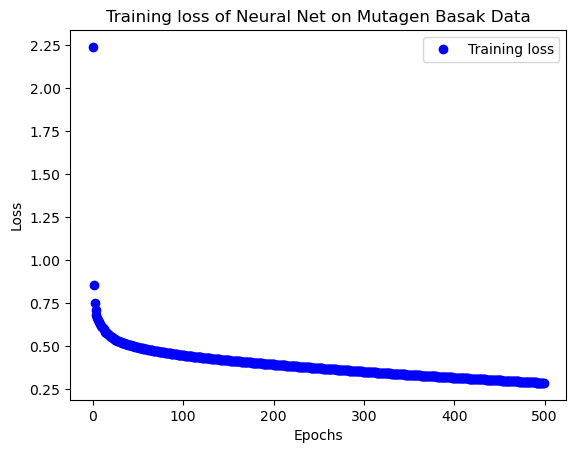

In [46]:
import matplotlib.pyplot as plt
epochcount = range(epochs)
plt.figure()
plt.plot(epochcount, losshistory, 'bo', label='Training loss')
plt.title('Training loss of Neural Net on Mutagen Basak Data')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [48]:
preds = autoencoder.predict(xtest)

35/35 [==============================] - 0s 386us/step


optimal mcc of 0.5676740448914002 at a threshold of 0.56


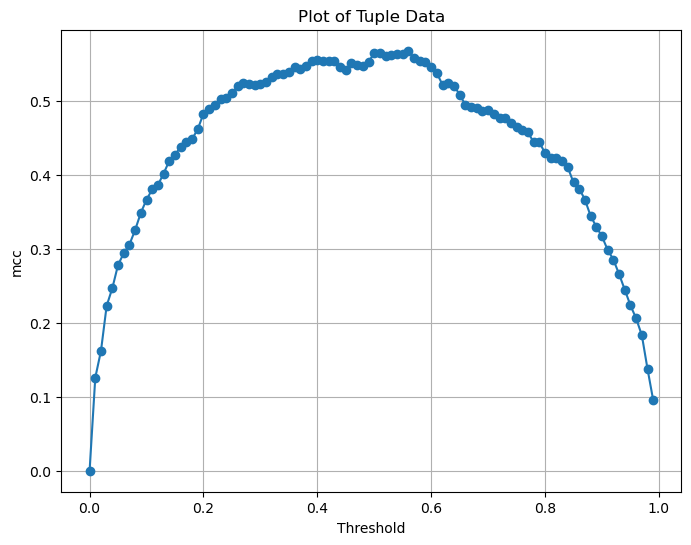

In [49]:
#acc curve creation
acclist = []
thresholdlist = []
maxval = 0
bestthresh = 0
for threshold in np.arange(0, 1, 0.01):
    #newval = acccalc(preds, threshold, ytrain)
    newval = acccalc(preds, threshold, ytest)
    acclist.append(newval)
    thresholdlist.append(threshold)
    if newval > maxval:
        maxval = newval
        bestthresh = threshold

import matplotlib.pyplot as plt
y_values = acclist
x_values = thresholdlist

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')

print('optimal mcc of', maxval, 'at a threshold of', bestthresh)

# Add titles and labels
plt.title('Plot of Tuple Data')
plt.ylabel('mcc')
plt.xlabel('Threshold')

# Display the plot
plt.grid(True)
plt.show()

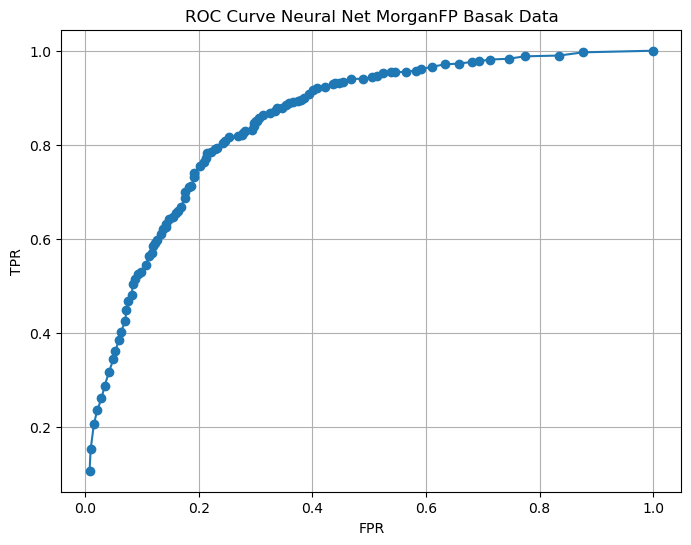

In [50]:
#ROC curve creation
ratelist = []
for threshold in np.arange(0, 1, 0.01):
    ratelist.append(ratecalc(preds, threshold, ytest))

import matplotlib.pyplot as plt
x_values = [x for x, y in ratelist]
y_values = [y for x, y in ratelist]

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')

# Add titles and labels
plt.title('ROC Curve Neural Net MorganFP Basak Data')
plt.xlabel('FPR')
plt.ylabel('TPR')

# Display the plot
plt.grid(True)
plt.show()

In [51]:
correctcount = 0
fpcount = 0
tpcount = 0
tncount = 0
fncount = 0
testpos = 0
testneg = 0

iterations = 0
for value in preds:
    testscore = ytest[iterations]
    #testscore = ytrain[iterations]
    if value > bestthresh:
        if testscore != 0:
            testpos = testpos + 1
            correctcount = correctcount + 1
            tpcount = tpcount + 1
        else:
            fpcount = fpcount + 1
            testneg = testneg + 1
    else:
        if testscore != 0:
            testpos = testpos + 1
            fncount = fncount + 1
        else:
            testneg = testneg + 1
            correctcount = correctcount + 1
            tncount = tncount + 1

    iterations = iterations + 1


print('positives in data', testpos)
print('negatives in data', testneg, '\n')

print('fn count =', fncount)
print('tn count =', tncount)

print('tp count =', tpcount)
print('fp count =', fpcount, '\n')

netfn = fncount / (fncount + tncount)
nettn = tncount / (fncount + tncount)
netacc = correctcount / (fpcount + fncount + tpcount + tncount)
posacc = tpcount / testpos
negacc = tncount / testneg
netfp = fpcount / (fpcount + tpcount)
nettp = tpcount / (tpcount + fpcount)

print('net accuracy =', netacc)
print('positive accuracy =', posacc)
print('negative accuracy =', negacc, '\n')

fpr = fpcount / (fpcount + tncount)
tpr = tpcount / (tpcount + fncount)

print('fpr =', fpr)
print('tpr =', tpr, '\n')

f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)
print('f1 score =',f1)

tp = tpcount
fp = fpcount
tn = tncount
fn = fncount

mcc = ((tp * tn) - (fp * fn)) / math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))

print('mcc =',mcc)

temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp

print('cohen Kappa =',kapp)

positives in data 586
negatives in data 526 

fn count = 127
tn count = 413
tp count = 459
fp count = 113 

net accuracy = 0.7841726618705036
positive accuracy = 0.7832764505119454
negative accuracy = 0.785171102661597 

fpr = 0.21482889733840305
tpr = 0.7832764505119454 

f1 score = 0.7927461139896373
mcc = 0.5678546510135529
cohen Kappa = 0.5676740448914002


In [52]:
#Checking if the model is overfit by assessing its values based on its predictions of xtrain

preds = autoencoder.predict(xtrain)
acclist = []
thresholdlist = []
maxval = 0
bestthresh = 0
for threshold in np.arange(0, 1, 0.01):
    newval = acccalc(preds, threshold, ytrain)
    acclist.append(newval)
    thresholdlist.append(threshold)
    if newval > maxval:
        maxval = newval
        bestthresh = threshold

correctcount = 0
fpcount = 0
tpcount = 0
tncount = 0
fncount = 0
testpos = 0
testneg = 0

iterations = 0
for value in preds:
    testscore = ytrain[iterations]
    if value > bestthresh:
        if testscore != 0:
            testpos = testpos + 1
            correctcount = correctcount + 1
            tpcount = tpcount + 1
        else:
            fpcount = fpcount + 1
            testneg = testneg + 1
    else:
        if testscore != 0:
            testpos = testpos + 1
            fncount = fncount + 1
        else:
            testneg = testneg + 1
            correctcount = correctcount + 1
            tncount = tncount + 1

    iterations = iterations + 1


print('positives in data', testpos)
print('negatives in data', testneg, '\n')

print('fn count =', fncount)
print('tn count =', tncount)

print('tp count =', tpcount)
print('fp count =', fpcount, '\n')

netfn = fncount / (fncount + tncount)
nettn = tncount / (fncount + tncount)
netacc = correctcount / (fpcount + fncount + tpcount + tncount)
posacc = tpcount / testpos
negacc = tncount / testneg
netfp = fpcount / (fpcount + tpcount)
nettp = tpcount / (tpcount + fpcount)

print('net accuracy =', netacc)
print('positive accuracy =', posacc)
print('negative accuracy =', negacc, '\n')

fpr = fpcount / (fpcount + tncount)
tpr = tpcount / (tpcount + fncount)

print('fpr =', fpr)
print('tpr =', tpr, '\n')

f1 = (2 * tpcount) / ((2 * tpcount) + fpcount + fncount)
print('f1 score =',f1)

tp = tpcount
fp = fpcount
tn = tncount
fn = fncount

mcc = ((tp * tn) - (fp * fn)) / math.sqrt((fp + tn) * (tp + fp) * (tp + fn) * (tn + fn))

print('mcc =',mcc)

temp = (( ( (tp + fp) * (fp + tn) ) + ( (tp + fn) * (fn + tn) ) ))
kapp =  ( 2 * ((tp * tn) - (fn * fp)) ) / temp

print('cohen Kappa =',kapp)

139/139 [==============================] - 0s 340us/step
positives in data 2402
negatives in data 2042 

fn count = 194
tn count = 1733
tp count = 2208
fp count = 309 

net accuracy = 0.8868136813681368
positive accuracy = 0.9192339716902581
negative accuracy = 0.8486777668952008 

fpr = 0.15132223310479923
tpr = 0.9192339716902581 

f1 score = 0.8977434437893881
mcc = 0.772223852007742
cohen Kappa = 0.7711662787478932
